<img src="http://www.ndbc.noaa.gov/images/stations/scripps.jpg" style="float: right;display:block;margin:auto;width:15%;"/>

# Humboldt Bay Wave Ridder Buoy: Real time standard meteorological data
### By Dustin Helliwell

This analysis will explore the last 45 days of [real time standard meteorological data](http://www.ndbc.noaa.gov/data/realtime2/46244.txt) from the the National Buoy Data Center's (NDBC) station 46244 - Humboldt Bay, North Spit, CA. The data will be presented as a series of tables and visualizations, produced with pandas, matplotlib and seaborn.

The NDBC provides data files for each of its stations, the following are the data files for buoy 46244:

|File             |Description                  
|-----------------|----------------------------
|46244.txt        | Real time standard meteorological data
|46244.data_spec  | Raw Spectral Wave Data     
|46244.spec       | Spectral Wave Summary Data
|46244.swdir      | Spectral Wave Data (alpha1)
|46244.swdir2     | Spectral Wave Data (alpha2)
|46244.swr1       | Spectral Wave Data (r1)
|46244.swr2       | Spectral Wave Data (r2)

Since only the "Real time standard meteorological data" will be used only [46244.txt](http://www.ndbc.noaa.gov/data/realtime2/46244.txt) will be downloaded.

To get started the raw data will be loaded into a data frame and the first few lines of data will be displayed. Each of the abbreviations in the table below are documented by the NDBC at the following link [Measurement Descriptions and Units](http://www.ndbc.noaa.gov/measdes.shtml).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def read_station(station_id, data_file):
    """Read data from NDBC to a pandas data frame.
    
    Read data from the National Data Buoy Center (NDBC) given the station number
    and data file extension.  Only the file extensions listed under the station_id 
    argument have been tested.
    
    Args:
        station_id: Five digit NDBC station id number.
        data_file: Must be on of the following strings 'txt', 'data_spec', 'spec', 
            'swdir','swdir2', 'swr1', or 'swr2'.
    
    Returns:
        A pandas data frame.
    """
    # Contruct url of data file.
    base = 'http://www.ndbc.noaa.gov/data/realtime2/'
    url = base + station_id + '.' + data_file

    # Set up keyword arguments for pd.read_csv().
    kwargs = {
        'index_col': 0,
        'delim_whitespace': True,
        'parse_dates': {'Date': [0, 1, 2, 3, 4]},
        'na_values': ['MM', -99, 999.0], }

    # Set up custom keyword arguments based on file type and read data. 
    if data_file == 'txt' or 'spec': # Spectral Wave Summary Data
        kwargs['header'] = 0
        kwargs['skiprows'] = [1]

        df = pd.read_csv(url, **kwargs)
    else: # Spectral Wave Files
        kwargs['header'] = None
        kwargs['skiprows'] = [0]
        spec = int(data_file == 'data_spec')
        kwargs['usecols'] = [0, 1, 2, 3, 4] + list(range(5 + spec, 132 + spec, 2))

        df = pd.read_csv(url, **kwargs)

        # Hard coded frequency headings.
        spec_heading = np.array([25 + 5 * num for num in range(0, 15)] + [101] +
                                [110 + 10 * num for num in range(0, 48)]
                               ) / 1000
        df.columns = spec_heading

    # Convert index to a pandas datetime object.
    df.index = pd.to_datetime(df.index, format="%Y %m %d %H %M")

    return df

# Read in raw data.
try:
    df_raw = pd.read_csv('real_time.csv', index_col='Date', date_parser=True)
except:
    df_raw = read_station('46244', 'txt')
    df_raw.to_csv('real_time.csv', float_format='%.3f') #Fix float round offs and save data.

df_raw.head(3)

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
Date,,,,,,,,,,,,,,
2017-06-16 19:51:00,NaN,NaN,NaN,2.0,11,7.9,281,NaN,NaN,14.8,NaN,NaN,NaN,NaN
2017-06-16 19:21:00,NaN,NaN,NaN,2.2,10,8.0,278,NaN,NaN,14.8,NaN,NaN,NaN,NaN
2017-06-16 18:51:00,NaN,NaN,NaN,2.3,10,8.2,288,NaN,NaN,14.7,NaN,NaN,NaN,NaN


## Convert Units

Most weather forecasts in the US use Fahrenheit and feet so the 'WVHT'(wave height) and 'WTMP' (water temperature) columns will be converted from metric units. Also, buoy 46244 only collects wave data and water temperature.  For this reason many columns have no data and are populated with NaN values.  These columns can be droped.

In [2]:
# Select only the columns that contain data.
df = df_raw[['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']].copy()

# Convert wave heights and temperatures to feet and Fahrenheit.
df['WVHT'] = np.around(df_raw.loc[:, 'WVHT']*3.28, decimals=1)
df['WTMP'] = np.around(df_raw.loc[:, 'WTMP']*(9/5)+32, decimals=1)

df.head()

,WVHT,DPD,APD,MWD,WTMP
Date,,,,,
2017-06-16 19:51:00,6.6,11,7.9,281,58.6
2017-06-16 19:21:00,7.2,10,8.0,278,58.6
2017-06-16 18:51:00,7.5,10,8.2,288,58.5
2017-06-16 18:21:00,8.2,11,8.6,285,58.3
2017-06-16 17:51:00,8.5,11,8.5,281,58.3


## Summarizing The Data
Generating some summary statistics is a good way to start exploring the data set. 

In [3]:
df.describe()

,WVHT,DPD,APD,MWD,WTMP
count,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000
mean,6.718410,10.441297,7.172590,296.999543,52.940384
std,2.737278,2.111788,0.963226,22.455858,1.900557
min,2.300000,5.000000,4.800000,205.000000,48.200000
25%,4.900000,9.000000,6.400000,288.000000,51.400000
50%,6.200000,10.000000,7.100000,297.000000,52.500000
75%,7.900000,11.000000,7.900000,311.000000,54.100000
max,17.700000,18.000000,10.800000,343.000000,58.600000


Notice the difference between the dominant period (DPD) and average period (APD) columns above. DPD is a measure of only the largest waves while APD is a measure of all waves. If DPD and APD are close then the largest waves are basically the only waves around, however if DPD and APD are very different then there are lots of smaller waves along with the big ones. It is interesting to keep this in mind while looking at the DPD and APD columns.

## Correlation Heatmap

Its also interesting to examine how this 45 day block of data correlates and speculate on the why it correlates.

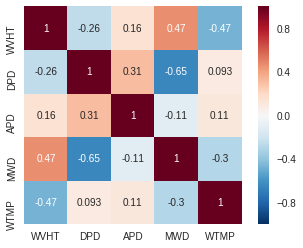

In [4]:
corr = df.corr()
fig, ax = plt.subplots() 

# Graph correlation matrix.
sns.heatmap(corr, ax=ax, square=True, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

- The negative correlation between 'WVHT' (wave height) and 'WTMP' (water temperature) may indicate that larger waves cause colder water from deep to mix with warmer surface water causing a lowering of temperature near the buoy.
- The high correlation between 'DPD' and 'APD' is probably because the dominant period is included in calculating the average period.
- The high positive correlation between 'APD' and 'WVHT' may be because wind can't make it as far into the troughs of large waves so less chop is generated.
- The positive correlation between 'DPD' and 'MWD' (mean wave direction) means that for this data longer period waves mostly came from the northwest (between $270^{\circ}$ and $360^{\circ}$) while shorter period waves came from the southwest (between $180^{\circ}$ and $270^{\circ}$).

More investigation would be needed to determine if the ideas in the first three bullets are true. The last bullet however describes a quality of this perticular 45 day block of data.  It is almost certain that another 45 day block of data could be selected where the correlation between 'DPD' and 'MWD' would be negative.  In this hypothetical case more long period waves would have come from the south.

## Plots and Histograms

Even more detail can be teased out of this data by plotting it over time.  Histograms are also included here for a quick look at how each column of data is distributed.

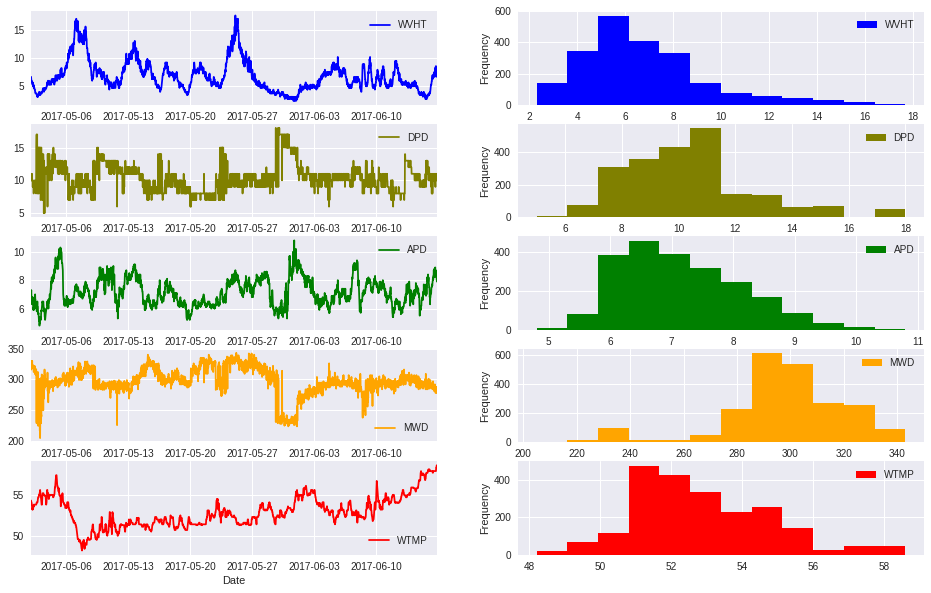

In [5]:
# Set up subplots and colors for plots.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))
colors = ['blue', 'olive', 'green', 'orange', 'red']

# Set up targets for each column in the data frame then plot them.
target = [axes[idx, 0] for idx in range(len(axes))]
df.plot(subplots=True, ax=target, color=colors)
    
# Plot the histogram for each plot next to the regular plot.
col = 1
for idx in range(len(axes)):
    df[[df.columns[idx]]].plot.hist(ax=axes[idx, col], bins=12, color=colors[idx])

Notice ‘WVHT’ and ‘WTMP’ graphs show the negative correlation reported by the correlation heatmap above.  The wave heights are highest in the middle of the plot while the water temperatures are lowest in the middle. 

Also notice that the graphs above show sudden large jumps for both ‘DPD’ and ‘MWD’.  This may indicate when a certain characteristic of the waves pass a threshold.  For example the ‘DPD’ may make a sudden jump when a new swell arrives and overtakes the old swell.  It is relevant to note that longer period waves have a higher velocity than shorter period waves.  

The sudden changes in ‘MWD’ could indicate a sudden increase in local wind causing the wind waves to steal dominance from swell.  Unless the swell and wind happen to be moving in the same direction this would show up as a sudden change in wave direction. 

## Polar Histogram

Showing the mean wave direction on a polar histogram makes it possible to see which directions waves were coming from without needing to see the numbers.  In this plot most of the waves came from a WNW direction.

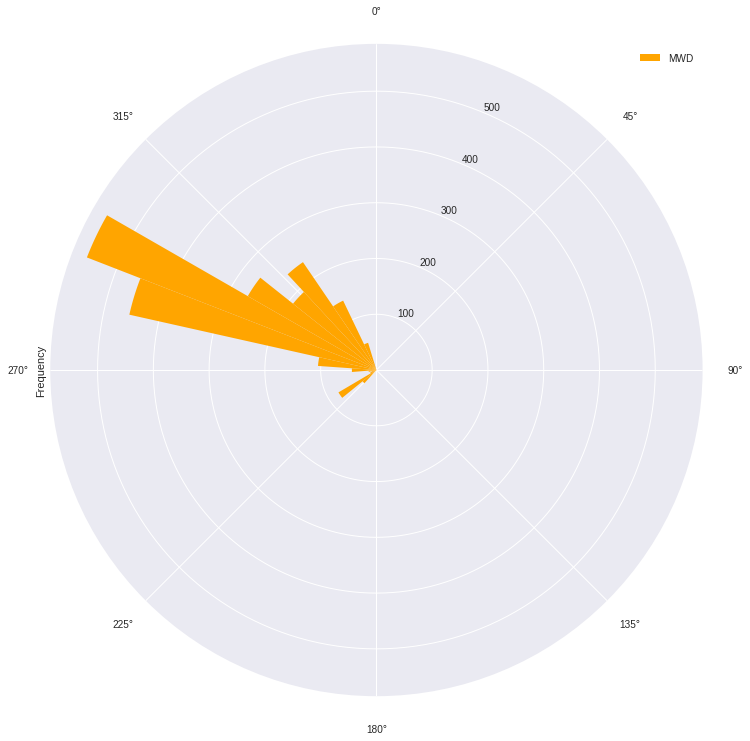

In [6]:
# Set up polar projection to correspond to the compass rose.
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(polar=True)
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)

# Plot histogram of wave direction.
np.radians(df[['MWD']]).plot.hist(ax=ax, bins=16, figsize=(12, 12), color='orange');

## Height, Period, and Direction In One Plot

The following presents 'WVHT', 'DPD', and 'MWD' in one plot.
- Wave size is shown by the relative size of each point.
- Period is shown with color.
- Wave direction is shown using polar axes.


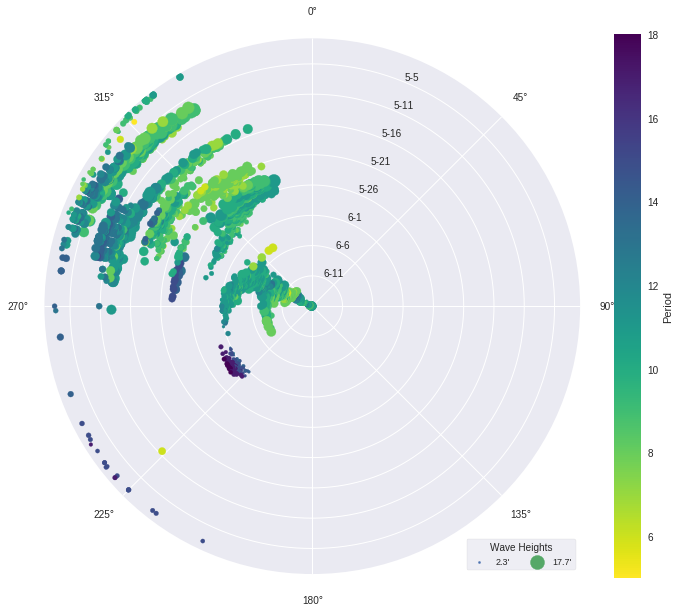

In [7]:
def lin_scale(array, sz_min, sz_max):
    """Scale a numpy array to span from sz_min to sz_max."""
    scale_diff = sz_max - sz_min
    lst_diff = max(array) - min(array)
    
    # Get the slope (m) and y-intercept (b) to scale the array.
    m = np.divide(scale_diff, lst_diff)
    b = np.divide(sz_min * max(array) - sz_max * min(array), lst_diff)
    
    return m * array + b

def polar_wave(df, height='WVHT', period='DPD', direction='MWD', ax=None):
    """Plot of wave height, period and direction on polar axes."""
    # Set up polar projection to correspond to the compass rose.
    if ax == None:
        fig = plt.figure(figsize=(12,10))
        ax = plt.subplot(polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    
    # Set up radius limits and create meaningful ytick (radius) labels.
    ax.set_rlim([0, len(df) + len(df)/100])
    tics = np.array(ax.get_yticks()).astype(int)
    dates = [df.index[tic] for tic in tics if tic < len(df)]
    tic_lables = [str(date.month) + '-' + str(date.day) for date in dates]
    ax.yaxis.set_ticklabels(tic_lables)

    # Set up scale for points sizes.
    pntsz_min = 5
    pntsz_max = 200
    scaled_heights = lin_scale(df[height], pntsz_min, pntsz_max)

    # Create plot and colorbar.
    sc = ax.scatter(y=range(len(df)), 
                    x=np.radians(df[direction]), 
                    c=df[period], 
                    s=scaled_heights,
                    cmap='viridis_r')
    cbar = plt.colorbar(sc);
    cbar.set_label('Period')

    # Create legend.
    label = str(df[height].max()) +'\''
    ax.scatter(x=[],y=[], 
               s=pntsz_min, 
               label=str(df[height].min()) + '\'')
    ax.scatter(x=[],y=[], 
               s=pntsz_max,
               label=str(df[height].max()) + '\'')
    plt.legend(title='Wave Heights', scatterpoints=1, fontsize=9, ncol=2, loc=4, frameon=True)
    return sc

polar_wave(df);

## Scatter Plot and Histogram Side by Side
Plotting the scatter plot and histogram side by side make the connections between the two very easy to see. The color of each bar in the histogram indicates the average dominant period of each wave in the bin.

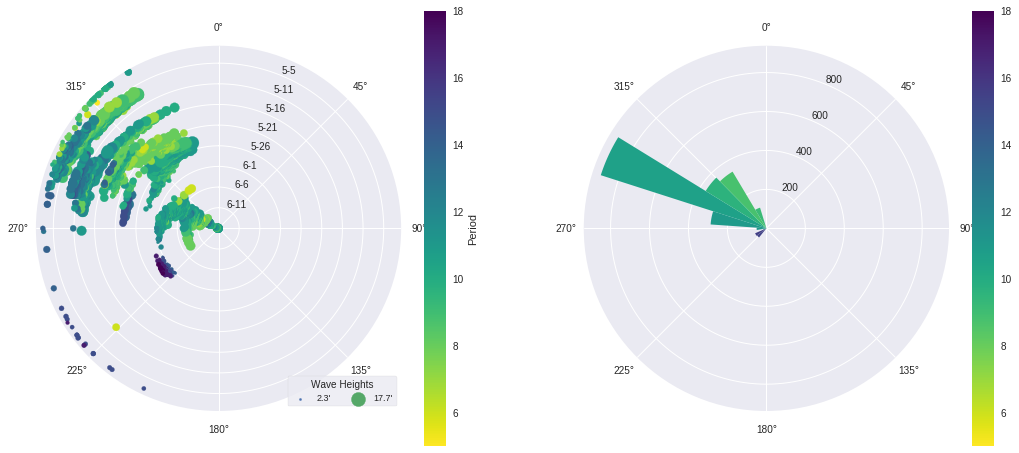

In [8]:
# Set up and plot polar scatter plot.
fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1, 2, 1, polar=True)
pw = polar_wave(df, period='DPD', ax=ax1)

# Set up and plot polar histogram.
ax2 = plt.subplot(1, 2, 2, polar=True)
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi/2)
n, bins, patches = ax2.hist(np.radians(df[['MWD']]).values)

# Color each bin to show the average period of the waves it counts.
bins = np.degrees(bins)
idx = 0
for patch in patches:
    # Get average period per bin
    ave_dpd = (df['DPD'][(df['MWD'] > bins[idx]) &
                         (df['MWD'] < bins[idx + 1])].mean())
    idx += 1
    plt.setp(patch, 'facecolor', pw.to_rgba(ave_dpd))
fig.colorbar(pw);